**Connect drive to Google Colab**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Imports**

In [6]:
import os
import numpy as np
import pandas as pd
import numpy as np
import pylab as plt
from torch import nn
import torch
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils.validation import check_array, check_consistent_length

In [8]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.22.2.post1.


**Functions**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None):
    """Mean absolute percentage error regression loss.
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    Returns
    -------
    loss : float or ndarray of floats in the range [0, 1/eps]
    """
    dtype="numeric"
    check_consistent_length(y_true, y_pred, sample_weight)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
    if Y_test.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    return np.average(output_errors, weights=None)

**Loading the dataset**

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/CDBC/'
data = pd.read_csv(os.path.join(data_dir,"data_CBDC.csv")).values
header = data[0,:]
data = data[1:,:]

X = data[:,0:6].astype(float)
Y = data[:, 6:].astype(float)
Y_perc = Y/np.sum(Y,axis=1).reshape(-1,1)

print(header)
print(X.shape) 
print(Y_perc.shape)

**Scale data**
This is used to convert the numbers in normal distribution format.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X= scaler.fit_transform(X)

**Preparing the test set and training set**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_perc, test_size=0.2, random_state=0)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

**Creating the DNN Architecture**

In [ ]:
class DNN(torch.nn.Module):
    '''Plain dense neural network of linear layers using dropout and ReLU activation.'''

    def __init__(self, inChannels, outChannels, hiddenChannels, dropout=0, bias=True):
        '''
        Defines a network accept input with `inChannels' channels, output of `outChannels' channels, and hidden layers
        with channels given in `hiddenChannels'. If `bias' is True then linear units have a bias term.
        '''
        super().__init__()
        self.inChannels = inChannels
        self.outChannels = outChannels
        self.dropout = dropout
        self.hiddenChannels = list(hiddenChannels)
        self.hiddens = torch.nn.Sequential()

        prevChannels = self.inChannels
        for i, c in enumerate(hiddenChannels):
            self.hiddens.add_module('hidden_%i' % i, self._getLayer(prevChannels, c, bias))
            prevChannels = c

        self.output = torch.nn.Linear(prevChannels, outChannels, bias)

    def _getLayer(self, inChannels, outChannels, bias):
        return torch.nn.Sequential(
            torch.nn.Linear(inChannels, outChannels, bias),
            torch.nn.Dropout(self.dropout),
            torch.nn.ReLU()
        )

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        x = self.hiddens(x)
        x = self.output(x)
        return F.softmax(x, 1)


**Training the DNN**

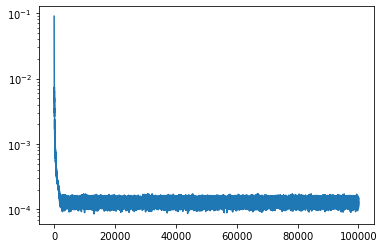

0.01
MAE: 0.01
MAPE: 0.04
R2: 0.49


<Figure size 432x288 with 0 Axes>

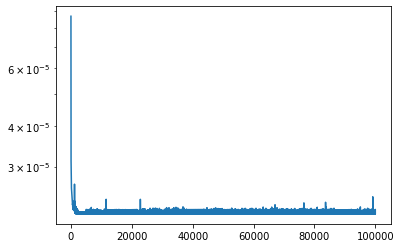

0.02
MAE: 0.00
MAPE: 0.02
R2: 0.85


<Figure size 432x288 with 0 Axes>

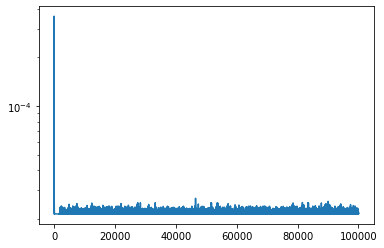

0.03
MAE: 0.00
MAPE: 0.02
R2: 0.85


<Figure size 432x288 with 0 Axes>

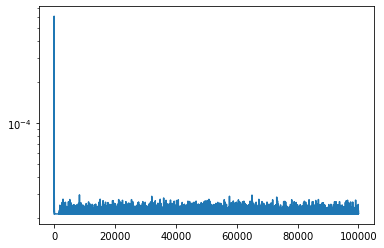

0.04
MAE: 0.00
MAPE: 0.02
R2: 0.84


<Figure size 432x288 with 0 Axes>

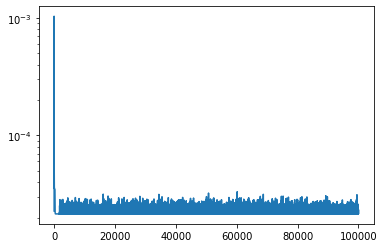

0.05
MAE: 0.00
MAPE: 0.02
R2: 0.84


<Figure size 432x288 with 0 Axes>

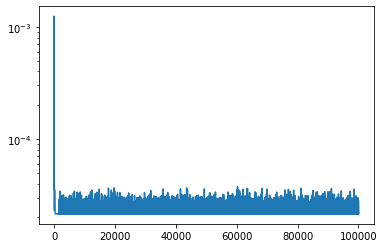

0.06
MAE: 0.00
MAPE: 0.02
R2: 0.84


<Figure size 432x288 with 0 Axes>

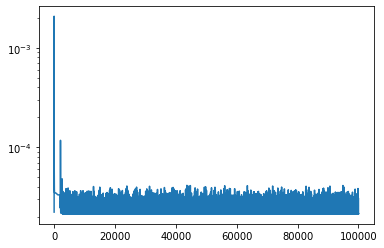

0.07
MAE: 0.00
MAPE: 0.02
R2: 0.84


<Figure size 432x288 with 0 Axes>

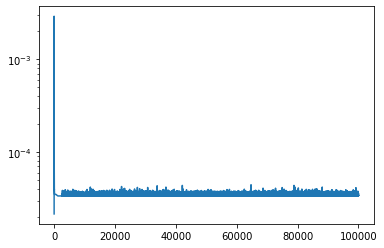

0.08
MAE: 0.00
MAPE: 0.03
R2: 0.72


<Figure size 432x288 with 0 Axes>

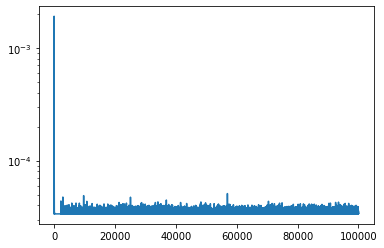

0.09
MAE: 0.00
MAPE: 0.03
R2: 0.71


<Figure size 432x288 with 0 Axes>

In [ ]:
net = DNN(inChannels=X_train.shape[1], outChannels=Y_train.shape[1], hiddenChannels=[4], dropout=0.5, bias=True)

xt = torch.from_numpy(X_train).type(torch.FloatTensor)
yt = torch.from_numpy(Y_train).type(torch.FloatTensor)


for lr in range(1,10):
  lr = lr/100
  opt = torch.optim.Adam(net.parameters(), lr=lr)

  criterion = nn.MSELoss() # this is for regression mean squared loss

  losses = []
  nb_iters = 100000
  for i in range(1, nb_iters + 1):
      out = net(xt)  # input x and predict based on x
      loss = criterion(out, yt)  # must be (1. nn output, 2. target), the target label is NOT one-hotted

      opt.zero_grad()  # clear gradients for next train
      loss.backward()  # backpropagation, compute gradients
      opt.step()  # apply gradients

      losses.append(loss.item())

  plt.figure()
  plt.semilogy(losses)
  plt.show()
  plt.savefig(os.path.join(data_dir, 'loss_lr_{}.png'.format(lr)))

  with torch.no_grad():
      net.eval()
      out = torch.from_numpy(X_test).float()
      y_pred = net(out).data.numpy()

      # Compute metrics - MAE
      print(lr)
      print('MAE: {:.2f}'.format(mean_absolute_error(Y_test, y_pred)))
      print('MAPE: {:.2f}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
      print('R2: {:.2f}'.format(r2_score(Y_test, y_pred))) 
  torch.save(net, os.path.join(data_dir, 'model_lr_{}.pth'.format(lr)))



**Load optimal model for inference**

In [ ]:
net = torch.load(os.path.join(data_dir, 'model_lr_0.03.pth'))

**Testing the DNN**

Compute the following metrics:

1) Mean Absolute Error (MAE):

2) Mean Absolute Percentage Error (MAPE): 

3) R-squared:



In [ ]:
with torch.no_grad():
    net.eval()
    out = torch.from_numpy(X_test).float()
    y_pred = net(out).data.numpy()

    # Compute metrics - MAE
    print('MAE: {:.4f}'.format(mean_absolute_error(Y_test, y_pred)))
    print('MAPE: {:.4f}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
    print('R2: {:.2f}'.format(r2_score(Y_test, y_pred))) 



MAE: 0.0027
MAPE: 0.0221
R2: 0.85


**CBDC** 

1) Prepare data

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/CDBC/'
data = pd.read_csv(os.path.join(data_dir,"data_CBDC_3.csv")).values
header = data[0,:]
data = data[1:,:]

X = data[:,0:8].astype(float)
Y = data[:, 8:].astype(float)

#scaler = MinMaxScaler()
#scaler.fit(X)
#X= scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

2) Train

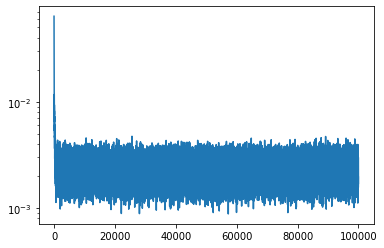

0.01
MAE: 0.02
MAPE: 0.10
R2: 0.33


<Figure size 432x288 with 0 Axes>

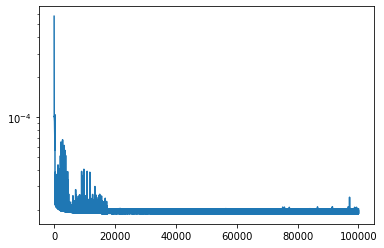

0.02
MAE: 0.00
MAPE: 0.04
R2: 0.72


<Figure size 432x288 with 0 Axes>

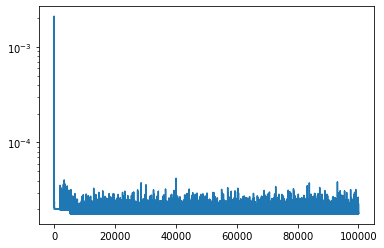

0.03
MAE: 0.00
MAPE: 0.03
R2: 0.76


<Figure size 432x288 with 0 Axes>

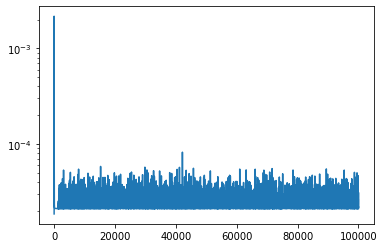

0.04
MAE: 0.00
MAPE: 0.03
R2: 0.76


<Figure size 432x288 with 0 Axes>

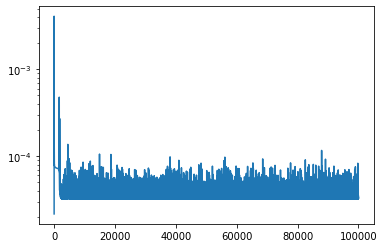

0.05
MAE: 0.00
MAPE: 0.03
R2: 0.74


<Figure size 432x288 with 0 Axes>

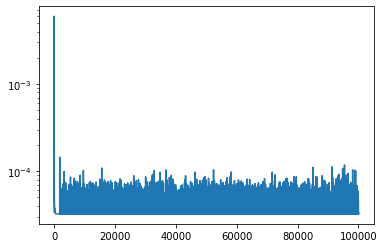

0.06
MAE: 0.00
MAPE: 0.03
R2: 0.74


<Figure size 432x288 with 0 Axes>

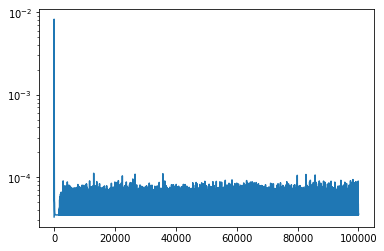

0.07
MAE: 0.01
MAPE: 0.04
R2: 0.75


<Figure size 432x288 with 0 Axes>

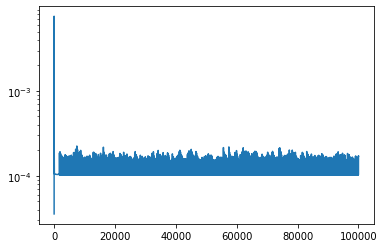

0.08
MAE: 0.01
MAPE: 0.06
R2: 0.66


<Figure size 432x288 with 0 Axes>

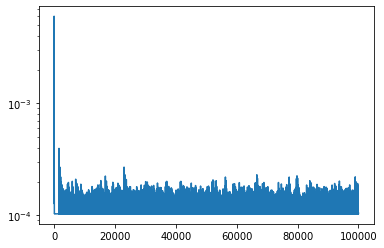

0.09
MAE: 0.01
MAPE: 0.06
R2: 0.66


<Figure size 432x288 with 0 Axes>

In [ ]:
net2 = DNN(inChannels=X_train.shape[1], outChannels=Y_train.shape[1], hiddenChannels=[5], dropout=0.5, bias=True)

xt = torch.from_numpy(X_train).type(torch.FloatTensor)
yt = torch.from_numpy(Y_train).type(torch.FloatTensor)


for lr in range(1,10):
  lr = lr/100
  opt = torch.optim.Adam(net2.parameters(), lr=lr)

  criterion = nn.MSELoss() # this is for regression mean squared loss

  losses = []
  nb_iters = 100000
  for i in range(1, nb_iters + 1):
      out = net2(xt)  # input x and predict based on x
      loss = criterion(out, yt)  # must be (1. nn output, 2. target), the target label is NOT one-hotted

      opt.zero_grad()  # clear gradients for next train
      loss.backward()  # backpropagation, compute gradients
      opt.step()  # apply gradients

      losses.append(loss.item())

  plt.figure()
  plt.semilogy(losses)
  plt.show()
  plt.savefig(os.path.join(data_dir, 'loss_CBDC_lr_{}.png'.format(lr)))

  with torch.no_grad():
      net2.eval()
      out = torch.from_numpy(X_test).float()
      y_pred = net2(out).data.numpy()

      # Compute metrics - MAE
      print(lr)
      print('MAE: {:.2f}'.format(mean_absolute_error(Y_test, y_pred)))
      print('MAPE: {:.2f}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
      print('R2: {:.2f}'.format(r2_score(Y_test, y_pred))) 
  torch.save(net2, os.path.join(data_dir, 'model_CBDC_lr_{}.pth'.format(lr)))



**Load optimal model for inference**

In [ ]:
net2 = torch.load(os.path.join(data_dir, 'model_CBDC_lr_0.03.pth'))

**Testing the DNN**

Compute the following metrics:

1) Mean Absolute Error (MAE):

2) Mean Absolute Percentage Error (MAPE): 

3) R-squared:



In [ ]:
with torch.no_grad():
    net2.eval()
    out = torch.from_numpy(X_test).float()
    y_pred = net2(out).data.numpy()

    # Compute metrics - MAE
    print('MAE: {:.4f}'.format(mean_absolute_error(Y_test, y_pred)))
    print('MAPE: {:.4f}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
    print('R2: {:.2f}'.format(r2_score(Y_test, y_pred))) 

MAE: 0.0040
MAPE: 0.0339
R2: 0.76


In [ ]:
X_test.shape

(21, 8)

In [ ]:
# ['I_CASH' 'I_DEP_HOUSE' 'I_DEP_CORP' 'I_CBDC' 'R_CASH' 'R_DEP_HOUSE' 'R_DEP_CORP' 'R_CBDC']
# Case 1:
Xt1 = np.array([0, 2.16, 1.92, 0, 0, 0.16, 0.16, 0])
Xt1 = Xt1.reshape(1,-1)
print(Xt1.shape)

# Case 2:
Xt2 = np.array([0, 2.16, 1.92, -0.4, 0, 0.16, 0.16, 0])
Xt2 = Xt2.reshape(1,-1)
print(Xt2)

# Case 2:
Xt3 = np.array([0, 2.16, 1.92, 0.6, 0, 0.16, 0.16, 0])
Xt3 = Xt3.reshape(1,-1)
print(Xt3)

with torch.no_grad():
    net2.eval()
    out = torch.from_numpy(Xt1).float()
    y_pred1 = net2(out).data.numpy()

    out = torch.from_numpy(Xt2).float()
    y_pred2 = net2(out).data.numpy()

    out = torch.from_numpy(Xt3).float()
    y_pred3 = net2(out).data.numpy()

# ['CASH_VOL' 'DEP_HOUSE_VOL' 'DEP_CORP_VOL' 'CBDC_VOL']
print(y_pred1)
print(y_pred2)
print(y_pred3)

(1, 8)
[[ 0.    2.16  1.92 -0.4   0.    0.16  0.16  0.  ]]
[[0.   2.16 1.92 0.6  0.   0.16 0.16 0.  ]]
[[0.04345633 0.64462197 0.12952732 0.18239436]]
[[0.0431781  0.6496889  0.12965834 0.17747459]]
[[0.04386236 0.6368825  0.1292878  0.18996733]]


In [ ]:
1)
[[0.04218619 0.18890253 0.03843031 0.730481  ]]
[[0.04202646 0.20181328 0.0426853  0.713475  ]]
[[0.0419859  0.20445713 0.04358222 0.70997477]]

2)[[0.0418212  0.18737388 0.04108299 0.7297219 ]]
[[0.04255893 0.19959484 0.04384192 0.7140043 ]]
[[0.04270127 0.2021011  0.04440854 0.7107891 ]]